Copyright (c) 2022 Graphcore Ltd. All rights reserved.

*Notebook autogenerated from OptimumWalkthrough.py on 16-Jun-2022*

Graphcore-optimum ViT demo on Chest X-ray Dataset
=================================================

First install the required packages.

In [ ]:
get_ipython().run_line_magic('pip', 'install pandas datasets torchvision==0.11.1 transformers optimum optimum-graphcore scikit-learn==0.24.2 matplotlib')

## Preparing the data

The NIH Chest X-ray Dataset can be download at https://nihcc.app.box.com/v/ChestXray-NIHCC

Bash to extract the files:
```
for f in images*.tar.gz; do tar xfz "$f"; done
```

In [2]:
import torch
import os
import shutil
import optimum.graphcore as optimum_graphcore
import transformers
import numpy as np
import pandas as pd
import contextlib
import io
from pathlib import Path
output = io.StringIO()

dataset_rootdir = "/localdata/ai-datasets/NIH-XRay"
# Path to the extracted "images" directory
images_dir = f"{dataset_rootdir}/images"

# Path to Data_Entry_2017_v2020.csv
data = pd.read_csv(f'{dataset_rootdir}/Data_Entry_2017_v2020.csv')

# We are going to import HuggingFace model from the checkpoint `google/vit-base-patch16-224-in21k` in this demo
model_name_or_path = "google/vit-base-patch16-224-in21k"

Prepare the environment and subdirectories.

In [3]:
# Find the path to /processed_images if you already completed the data processing section
root_dir = Path(images_dir).parent.absolute()
processed_imagedir = root_dir / "processed_images"

# Don't want to have spaces in folder names
data['Finding Labels'] = data['Finding Labels'].str.replace('No Finding', 'No_Finding')

# Some images have multiple labels
# We split them into columns
findings = data['Finding Labels'].str.split('|', expand=True)

# Some images have multiple labels, we keep only the first one
data['Finding Labels'] = findings[0]
labels = data['Finding Labels'].unique()

# Print information about the dataset
data['Finding Labels'].unique()
data['Finding Labels'].value_counts()

if not processed_imagedir.exists():
    processed_imagedir.mkdir(parents=True)
    for l in labels:
        (processed_imagedir / l).mkdir()
    # Copy each image to its label subfolder
    for image, label in zip(data['Image Index'], data['Finding Labels']):
        shutil.copy(Path(images_dir) / image, processed_imagedir / label)
print(f"Processed images are in: '{processed_imagedir}'")

Create the Pytorch dataset and split it into training and validation sets (can take a few minutes).

In [4]:
import datasets

train_val_split = 0.1
dataset = datasets.load_dataset(
    "imagefolder",
    data_dir=processed_imagedir,
    task="image-classification",
)

split = dataset["train"].train_test_split(train_val_split)
dataset["train"] = split["train"]
dataset["validation"] = split["test"]

Resolving data files:   0%|          | 0/112120 [00:00<?, ?it/s]

Using custom data configuration default-4b8408820badc944
Reusing dataset image_folder (/home/alexandrec/.cache/huggingface/datasets/image_folder/default-4b8408820badc944/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /home/alexandrec/.cache/huggingface/datasets/image_folder/default-4b8408820badc944/0.0.0/48efdc62d40223daee675ca093d163bcb6cb0b7d7f93eb25aebf5edca72dc597/cache-b93a00f258f9d717.arrow


Define data preprocessing steps using Pytorch transforms.

In [5]:
from torchvision import transforms

feature_extractor = transformers.AutoFeatureExtractor.from_pretrained(
    model_name_or_path
)


class XRayTransform:
    """
    Transforms for pre-processing XRay data across a batch.
    """
    def __init__(self):
        self.transforms = transforms.Compose([
            transforms.Lambda(lambda pil_img: pil_img.convert("RGB")),
            transforms.Resize(feature_extractor.size),
            transforms.ToTensor(),
            transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std),
        ])

    def __call__(self, example_batch):
        example_batch["pixel_values"] = [self.transforms(pil_img) for pil_img in example_batch["image"]]
        return example_batch


# Set the training transforms
dataset["train"].set_transform(XRayTransform())
# Set the validation transforms
dataset["validation"].set_transform(XRayTransform())

Finally, define a data collator that will be used to construct the batches.

In [6]:
def batch_sampler(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["labels"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

## Visualise the data

Print the first 10 labels

In [7]:
data.head(10)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y]
0,00000001_000.png,Cardiomegaly,0,1,57,M,PA,2682,2749,0.143,0.143
1,00000001_001.png,Cardiomegaly,1,1,58,M,PA,2894,2729,0.143,0.143
2,00000001_002.png,Cardiomegaly,2,1,58,M,PA,2500,2048,0.168,0.168
3,00000002_000.png,No_Finding,0,2,80,M,PA,2500,2048,0.171,0.171
4,00000003_001.png,Hernia,0,3,74,F,PA,2500,2048,0.168,0.168
5,00000003_002.png,Hernia,1,3,75,F,PA,2048,2500,0.168,0.168
6,00000003_003.png,Hernia,2,3,76,F,PA,2698,2991,0.143,0.143
7,00000003_004.png,Hernia,3,3,77,F,PA,2500,2048,0.168,0.168
8,00000003_005.png,Hernia,4,3,78,F,PA,2686,2991,0.143,0.143
9,00000003_006.png,Hernia,5,3,79,F,PA,2992,2991,0.143,0.143


Prepare the label mappings.
We'll include these in the model's config to get human readable labels in the Inference API.

In [8]:
labels = dataset["train"].features["labels"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

Let's plot 10 images from the validation set with their associated labels.

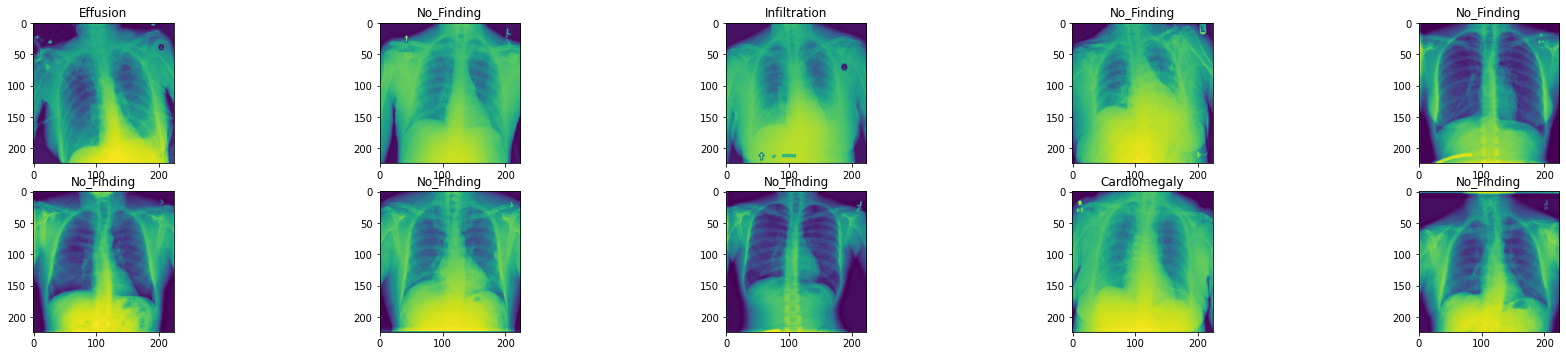

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(30, 15))

for i, data_dict in enumerate(dataset['validation']):
    if i == 10:
        break
    image = data_dict["pixel_values"]
    label = data_dict["labels"]
    ax = plt.subplot(5, 5, i + 1)
    ax.set_title(id2label[str(label)])
    plt.imshow(image[0])

## Preparing the model

Import the ViT model from HuggingFace.

In [10]:
model = transformers.AutoModelForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    label2id=label2id,
    id2label=id2label,
)

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`IPUConfig` is a specific arguments class defined by Optimum-graphcore.
It gives control to all the parameters specific to Graphcore's IPUs.
Existing IPU configs can be found at : https://huggingface.co/Graphcore
We are going to use `Graphcore/vit-base-ipu`.

In [11]:
ipu_config = optimum_graphcore.IPUConfig.from_pretrained(
    "Graphcore/vit-base-ipu"
)

Let's set our training hyperparameters using `IPUTrainingArguments`.
This subclasses HuggingFace's `TrainingArguments` with additional parameters.

In [12]:
training_args = optimum_graphcore.IPUTrainingArguments(
    output_dir="./results",
    per_device_train_batch_size=1,
    per_device_eval_batch_size=1,
    dataloader_num_workers=8,
    dataloader_drop_last=True,
    num_train_epochs=3,
    seed=1337,
    logging_steps=50,
    save_steps=1000,
    remove_unused_columns=False,
    warmup_ratio=0.25,
    lr_scheduler_type="cosine",
    learning_rate=2e-4,
    ignore_data_skip=True
)

To assess the performance of the model we will use the following metrics:
- single label accuracy (`accuracy`);
- and the area under the  ROC (receiver operating characteristic) curve for assessing the multi-label performance (`roc_auc`).
We obtain them using the dataset package.
Let's also define our `compute_metrics` function. It takes an `EvalPrediction` object (a namedtuple with a predictions and label_ids field) and has to return a dictionary string to float.

In [13]:
from scipy.special import softmax

metric_acc = datasets.load_metric("accuracy")
metric_auc = datasets.load_metric("roc_auc", "multiclass")


def compute_metrics(p):
    preds = np.argmax(p.predictions, axis=1)
    acc = metric_acc.compute(predictions=preds, references=p.label_ids)['accuracy']

    pred_scores = softmax(p.predictions.astype('float32'), axis=1)
    auc = metric_auc.compute(prediction_scores=pred_scores, references=p.label_ids, multi_class='ovo')['roc_auc']
    return {"accuracy": acc, "roc_auc": auc}

`IPUTrainer` works just like HF `Trainer`, it takes the additional `ipu_config` arguments.

In [14]:
trainer = optimum_graphcore.IPUTrainer(
    model=model,
    ipu_config=ipu_config,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    compute_metrics=compute_metrics,
    tokenizer=feature_extractor,
    data_collator=batch_sampler,
)

Setting replicated_tensor_sharding to False when replication_factor=1
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------


## Run the training

To accelerate training we will load the last checkpoint if it exists

In [15]:
last_checkpoint = None
if os.path.isdir(training_args.output_dir) and not training_args.overwrite_output_dir:
    last_checkpoint = transformers.trainer_utils.get_last_checkpoint(training_args.output_dir)

Now we are ready to train.

In [16]:
with contextlib.redirect_stdout(output):
    trainer.train(resume_from_checkpoint = last_checkpoint)

Compiling Model...
/localdata/alexandrec/sdks/poplar_sdk-ubuntu_18_04-2.6.0-EA.1+1025-ae1b174852/2.6.0-EA.1+1025_poptorch/lib/python3.6/site-packages/transformers/models/vit/modeling_vit.py:186: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if height != self.image_size[0] or width != self.image_size[1]:
Graph compilation: 100%|██████████| 100/100 [00:10<00:00]
Compiled/Loaded model in 54.753591407090425 secs
***** Running training *****
  Num examples = 100908
  Num Epochs = 3
  Instantaneous batch size per device = 1
  Device Iterations = 1
  Replication Factor = 1
  Gradient Accumulation steps = 128
  Total train batch size (w. parallel, distributed & accumulation) = 128
  Total optimization steps = 2364
wandb: Currently logged in as: alexandrec. Use `wandb login --r

  0%|          | 0/2364 [00:00<?, ?it/s]

Saving model checkpoint to ./results/checkpoint-1000
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Configuration saved in ./results/checkpoint-1000/ipu_config.json
Saving model checkpoint to ./results/checkpoint-2000
---------- Device Allocation -----------
Embedding  --> IPU 0
Encoder 0  --> IPU 0
Encoder 1  --> IPU 0
Encoder 2  --> IPU 0
Encoder 3  --> IPU 1
Encoder 4  --> IPU 1
Encoder 5  --> IPU 1
Encoder 6  --> IPU 2
Encoder 7  --> IPU 2
Encoder 8  --> IPU 2
Encoder 9  --> IPU 3
Encoder 10 --> IPU 3
Encoder 11 --> IPU 3
Head       --> IPU 3
---------------------------------------
Configuration saved in ./results/checkpoint-2000/ipu_config.json


Training com

### Plotting convergence
Let's format the trainer output.

In [17]:
import json
# Visualise a fragment of the raw output
print(output.getvalue()[:500])
print("...")
print(output.getvalue()[-500:])

# Put the trainer logs in a data frame
values = []
for line in output.getvalue().split("\n"):
    if len(line) > 3 and line[:3] == "{'l":
        values.append(json.loads(line.replace("'", '"')))
training_records = pd.DataFrame(values)
training_records.tail(5)

{'loss': 2.2986, 'learning_rate': 1.6920473773265652e-05, 'epoch': 0.06}
{'loss': 2.0276, 'learning_rate': 3.3840947546531304e-05, 'epoch': 0.13}
{'loss': 1.9455, 'learning_rate': 5.076142131979695e-05, 'epoch': 0.19}
{'loss': 1.4724, 'learning_rate': 6.768189509306261e-05, 'epoch': 0.25}
{'loss': 1.4425, 'learning_rate': 8.460236886632826e-05, 'epoch': 0.32}
{'loss': 1.8355, 'learning_rate': 0.0001015228426395939, 'epoch': 0.38}
{'loss': 1.9346, 'learning_rate': 0.00011844331641285957, 'epoch':
...
: 1.1031, 'learning_rate': 7.103458838758869e-06, 'epoch': 2.73}
{'loss': 1.0514, 'learning_rate': 4.192583130930605e-06, 'epoch': 2.79}
{'loss': 1.583, 'learning_rate': 2.0332218553618885e-06, 'epoch': 2.86}
{'loss': 1.1892, 'learning_rate': 6.423130656615483e-07, 'epoch': 2.92}
{'loss': 1.4524, 'learning_rate': 3.0767065682613116e-08, 'epoch': 2.98}
{'train_runtime': 964.3772, 'train_samples_per_second': 313.906, 'train_steps_per_second': 2.451, 'train_loss': 1.4306895196336982, 'epoch': 

,loss,learning_rate,epoch
42,1.1031,7.103459e-06,2.73
43,1.0514,4.192583e-06,2.79
44,1.5830,2.033222e-06,2.86
45,1.1892,6.423131e-07,2.92
46,1.4524,3.076707e-08,2.98


Plot the training loss and the learning rate.

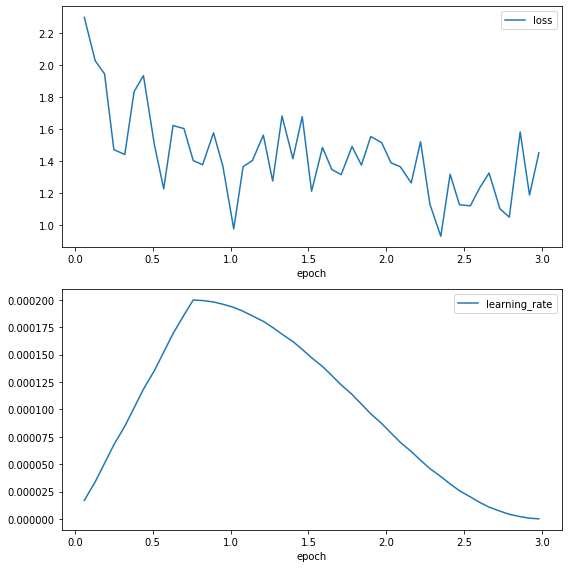

In [18]:
fig, axs = plt.subplots(2, 1)
training_records.plot(x="epoch", y="loss", ax=axs[0])
training_records.plot(x="epoch", y="learning_rate", ax=axs[1])
fig.set_size_inches(8, 8)
fig.tight_layout()

## Run the evaluation

In [19]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

Compiling Model...
Graph compilation: 100%|██████████| 100/100 [00:03<00:00]
Compiled/Loaded model in 47.42971400171518 secs
***** Running Evaluation *****
  Num examples = 11212
  Batch size = 4


  0%|          | 0/2803 [00:00<?, ?it/s]

***** eval metrics *****
  epoch                   =        3.0
  eval_accuracy           =     0.5746
  eval_loss               =     1.3486
  eval_roc_auc            =     0.7602
  eval_runtime            = 0:00:48.30
  eval_samples_per_second =    232.091
  eval_steps_per_second   =     58.023


This basic demo achieved a validation AUC_ROC score of 0.76 after 3 epochs.
There are several directions to explore in order to improve it: longer training, data augmentation and hyperparameters tuning.

## Conclusion

Optimum-graphcore makes state-of-the-art models from HuggingFace available on IPU with a minimal amount of code.
Pre-set device parameters can be loaded and customised in `IPUConfig`.